In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint

In [6]:
ztL = torch.rand((1,250,5,1))

In [7]:
z = ztL.squeeze(0)

In [8]:
z.shape

torch.Size([250, 5, 1])

In [19]:
ztL.shape

torch.Size([5, 25, 1, 8])

In [20]:
ztL = ztL.reshape((5,25,-1))

In [21]:
ztL.shape

torch.Size([5, 25, 8])

In [17]:
cL = torch.rand((5,25,10))

In [18]:
st = torch.cat([ztL,cL])

RuntimeError: Tensors must have same number of dimensions: got 4 and 3

In [13]:
ztL = ztL.reshape(5,25,16,-1)

In [14]:
ztL.shape

torch.Size([5, 25, 16, 16])

In [4]:
z0.ndim

2

In [7]:
z0L = torch.stack([z0]*5)

In [8]:
z0L.shape

torch.Size([5, 25, 8])

In [9]:
z0L.ndim

3

In [10]:
for z in z0L:
    print(z.shape)

torch.Size([25, 8])
torch.Size([25, 8])
torch.Size([25, 8])
torch.Size([25, 8])
torch.Size([25, 8])


Sin data

In [11]:
def gen_sin_data(data_path, N, T=50, dt=0.1, sig=.1): 
    phis = torch.rand(N,1) #
    fs = torch.rand(N,1) * .5 + .5 # N,1, [0.5, 1.0]
    A  = torch.rand(N,1) * 2 + 1   # N,1, [1.0, 3.0]
    ts = torch.arange(T) * dt # T
    ts = torch.stack([ts]*N)  # N,T
    ts = (ts*fs+phis) * 2*np.pi # N,T
    X  = ts.sin() * A
    X += torch.randn_like(X)*sig
    X = X.unsqueeze(-1)
    return X
	#torch.save(X, data_path)



In [22]:
X = gen_sin_data('', N=1, T=50, dt=0.1, sig=.1)

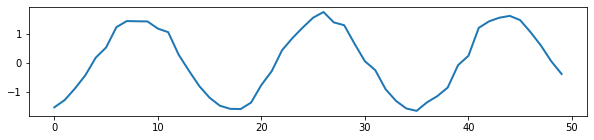

In [23]:

N = min(X.shape[0],6)
D = min(X.shape[-1],3)
Xnp    = X.detach().cpu().numpy()
nc,nr = D, N
fig, axes = plt.subplots(nr, nc, figsize=(nc*10,nr*2), squeeze=False)
for n in range(N):
    for d in range(D):
        axes[n,d].plot(Xnp[n,:,d].T, '-', color='tab:blue', lw=2)
plt.show()

In [9]:
X = torch.load('data/sin/sin-data.pkl')

In [10]:
X.shape

torch.Size([8100, 50, 1])

In [12]:
from   torch.utils import data
class Dataset(data.Dataset):
	def __init__(self, Xtr):
		self.Xtr = Xtr # N,T,_
	def __len__(self):
		return len(self.Xtr)
	def __getitem__(self, idx):
		return self.Xtr[idx]
	@property
	def shape(self):
		return self.Xtr.shape

In [13]:
trainset = Dataset(X)
params = {'batch_size': 25, 'shuffle': True, 'num_workers': 0}
trainset = data.DataLoader(trainset, **params)

In [17]:
tr_minibatch = next(iter(trainset))

In [18]:
tr_minibatch.shape

torch.Size([25, 50, 1])

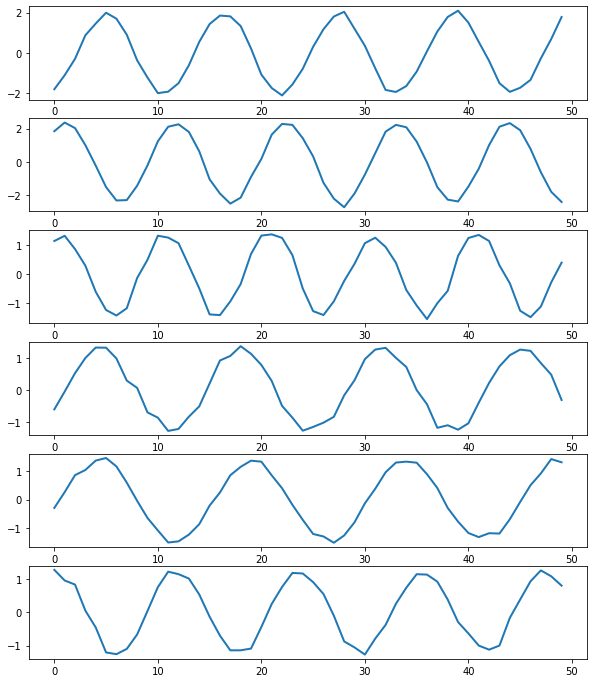

In [19]:

N = min(tr_minibatch.shape[0],6)
D = min(tr_minibatch.shape[-1],3)
Xnp    = tr_minibatch.detach().cpu().numpy()
nc,nr = D, N
fig, axes = plt.subplots(nr, nc, figsize=(nc*10,nr*2), squeeze=False)
for n in range(N):
    for d in range(D):
        axes[n,d].plot(Xnp[n,:,d].T, '-', color='tab:blue', lw=2)
plt.show()

In [33]:
T

50

In [22]:
[N,T] = tr_minibatch.shape[:2]
T_  = min(T, ep//40+5)

In [23]:
T_

5

In [ ]:
if T_ < T:
    N_  = int(N*(T//T_))
    t0s = torch.randint(0,T-T_,[N_]) 
    tr_minibatch = tr_minibatch.repeat([N_,1,1])
    tr_minibatch = torch.stack([tr_minibatch[n,t0:t0+T_] for n,t0 in enumerate(t0s)]) # N*ns,T//2,d

In [34]:
N_  = int(N*(T//T_))

In [47]:
N_

250

In [37]:
t0s = torch.randint(0,T-T_,[N_]) 

In [39]:
tr_minibatchn = tr_minibatch.repeat([N_,1,1])

In [40]:
tr_minibatchn.shape

torch.Size([6250, 50, 1])

In [45]:
tr_minibatchnn = torch.stack([tr_minibatchn[n,t0:t0+T_] for n,t0 in enumerate(t0s)])

In [46]:
tr_minibatchnn.shape

torch.Size([250, 5, 1])

Spiral ODE dataset

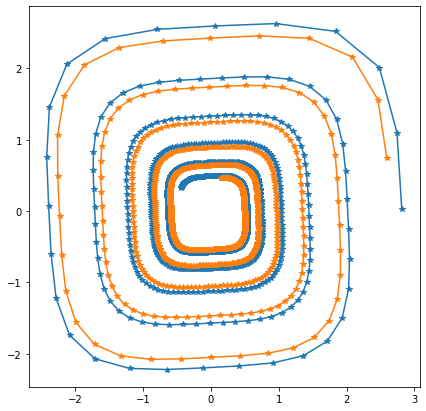

In [5]:
N = 2

A  = torch.tensor(np.array([[-0.1, 2.0], [-2.0, -0.1]]))

def odef(t, x, A):
    return (x**3) @ A

odef_ = lambda t,x: odef(t,x,A)

x0 = torch.tensor(np.array([[2.0,0.0]])).repeat(N,1)
x0 = x0 + 1*torch.rand_like(x0)
ts = torch.linspace(0,25,1001)


xt = odeint(odef_, x0, ts, method='dopri5') # T,N,n
plt.figure(1,(7,7))
for i in range(2):
    plt.plot(xt[:,i,0], xt[:,i,1], '*-')
plt.show()

LV dataset

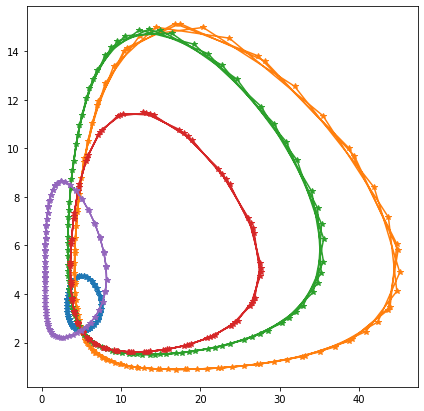

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint


N = 10

alpha = torch.rand([N,1]) / .3 + .1
gamma = torch.rand([N,1]) / .3 + .1
beta  = 0.5
delta = 0.2

def odef(t,state,alpha,beta,gamma,delta):
    x,y = state.split([1,1],dim=-1) # M,1 & M,1
    dx = alpha*x   - beta*x*y # M,1
    dy = delta*x*y - gamma*y  # M,1
    return torch.cat([dx,dy],-1)

odef_ = lambda t,x: odef(t,x,alpha,beta,gamma,delta)

x0 = torch.tensor(np.array([5.0,2.5])).repeat(N,1) 
# x0 = x0 + 10*torch.rand_like(x0)
ts = torch.linspace(0,10,101)


xt = odeint(odef_, x0, ts, method='dopri5') # T,N,n
plt.figure(1,(7,7))
for i in range(5):
    plt.plot(xt[:,i,0], xt[:,i,1], '*-')
plt.show()